# LSTM 으로 분류기 구현하기
File 의 리스트를 받아와서 해당 데이터들을 가공하고 Y 값을 one-hot 인코딩하여 분류를 해주는 형태로 답이 나오게 구현해본다.

# 1. 구글마운트

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


- 데이터 위치로 이동

In [2]:
%cd '/gdrive/MyDrive/KerasStudy/06.RNN/data'

/gdrive/MyDrive/KerasStudy/06.RNN/data


# 2. file list 가져오기

In [3]:
import os
path_dir = './'
file_list = os.listdir(path_dir)
print(file_list)

['a_001.csv', 'a_006.csv', 'b_002.csv', 'b_004.csv', 'c_003.csv', 'c_005.csv']


# 3. 데이터셋 만들기

## 파일 불러옴

### X 값 불러오면서 Y 값 만듦.

In [4]:
import numpy as np
import pandas as pd

em_x = []
em_y = []
for i in file_list :
  tempstr = './'+i
  em_x.append(np.array(pd.read_csv(tempstr)))
  em_y.append(i[0])

- y 값 확인

In [5]:
print(file_list)
print(em_y)

['a_001.csv', 'a_006.csv', 'b_002.csv', 'b_004.csv', 'c_003.csv', 'c_005.csv']
['a', 'a', 'b', 'b', 'c', 'c']


- x 값 확인

In [6]:
em_x2 = np.array(em_x)
em_x2[0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(72, 7)

### y 값 원 핫 인코딩

In [7]:
reshape_ha = list(em_y)
new_list = []
for v in reshape_ha:
    if v not in new_list:
        new_list.append(v)
print(new_list)

['a', 'b', 'c']


In [8]:
reshape_ha
lst_set=new_list
enc={v:k for k,v in enumerate(lst_set)}
dec={k:v for k,v in enumerate(reshape_ha)}

In [9]:
print(enc)

{'a': 0, 'b': 1, 'c': 2}


In [10]:
lst_e = [enc[i] for i in reshape_ha]
lst_e

[0, 0, 1, 1, 2, 2]

In [11]:
ohe=np.eye( len(enc.keys() ))
ohe

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [12]:
temp_elst = [ohe[i] for i in lst_e]
temp_elst

[array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([0., 0., 1.])]

In [13]:
em_y2 = np.array(temp_elst)

## 학습형태로 만들어주기
- 10개 씩 끊어서 LSTM 에서 학습할 수 있게 만들어 줌.
- npx == test_x, npy == test_y

In [14]:
#, callbacks=[early_stop]
frame = 10 # 몇개 단위로 가져올지를 결정
# for 문을 통해 100개 단위로 학습을 하는 부분임.
npx = []
npy = []
for fileidx in range(0,len(em_x2)):
  # storeID 당 최대 갯수를 지정
  endpoint = int (em_x2[fileidx].shape[0])
  for i in range(0,endpoint,1):
    # 1 개씩 하는 것이 시간이 오래 걸리는 관계로 100단위로 쪼개서 하기 위해 인덱스 지정
    idx = (i+10)
    idx2 = int(idx+1)
    if idx2 >= endpoint :
      break;
    else:
      npx.append(em_x2[fileidx][i:idx])
      npy.append(em_y2[fileidx])
npx = np.array(npx)
npy = np.array(npy)
print(npx.shape, npy.shape)

(206, 10, 7) (206, 3)


## train_test_split
train_test_split 을 통해 학습데이터와 테스트데이터를 나눠주고 그 과정에서 셔플링을 실행해준다.

In [15]:
from sklearn.model_selection import train_test_split
# shuffle = True
X_train, test_X, y_train, test_y = train_test_split(npx,  npy, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=1004)

# 4. LSTM 모델 만들기

In [16]:
from tensorflow import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping


In [17]:
em_x2[0].shape[1]

7

## 모델 구성
- 들어오는 데이터의 약 2배 이상의 히든레이어 생성
- y 값에 맞춰 3 개를 softmax 형태로 아웃풋 지정

In [18]:

K.clear_session()
model = Sequential() # Sequeatial Model 
model.add(LSTM(32, input_shape=( 10,  em_x2[0].shape[1]),activation='sigmoid')) # (timestep, feature) 
model.add(Dense(3,activation='softmax')) # output = 1
# admax = keras.optimizers.Adamax(learning_rate=0.12, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
# model.compile(optimizer=admax, loss='mse')
admax = keras.optimizers.Adamax(learning_rate=0.12, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mse', optimizer=admax)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 5,219
Trainable params: 5,219
Non-trainable params: 0
_________________________________________________________________


## 학습 진행

In [19]:
history = model.fit(npx,npy,batch_size=2,epochs=100, verbose=2, validation_data=(test_X, test_y))

Epoch 1/100
103/103 - 2s - loss: 0.1545 - val_loss: 0.0229
Epoch 2/100
103/103 - 0s - loss: 0.0032 - val_loss: 3.9460e-04
Epoch 3/100
103/103 - 0s - loss: 2.4400e-04 - val_loss: 1.8226e-04
Epoch 4/100
103/103 - 0s - loss: 1.3304e-04 - val_loss: 1.1451e-04
Epoch 5/100
103/103 - 0s - loss: 8.8604e-05 - val_loss: 8.0529e-05
Epoch 6/100
103/103 - 0s - loss: 6.4636e-05 - val_loss: 6.0404e-05
Epoch 7/100
103/103 - 0s - loss: 4.9589e-05 - val_loss: 4.7313e-05
Epoch 8/100
103/103 - 0s - loss: 3.9417e-05 - val_loss: 3.8247e-05
Epoch 9/100
103/103 - 0s - loss: 3.2119e-05 - val_loss: 3.1431e-05
Epoch 10/100
103/103 - 0s - loss: 2.6649e-05 - val_loss: 2.6142e-05
Epoch 11/100
103/103 - 0s - loss: 2.2424e-05 - val_loss: 2.2150e-05
Epoch 12/100
103/103 - 0s - loss: 1.9072e-05 - val_loss: 1.8889e-05
Epoch 13/100
103/103 - 0s - loss: 1.6363e-05 - val_loss: 1.6269e-05
Epoch 14/100
103/103 - 0s - loss: 1.4148e-05 - val_loss: 1.4050e-05
Epoch 15/100
103/103 - 0s - loss: 1.2289e-05 - val_loss: 1.2259e-05
E

## 학습 히스토리

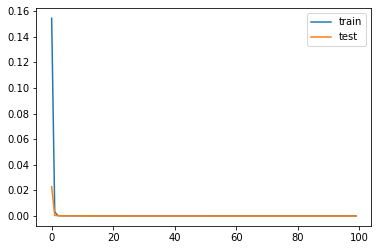

In [20]:
# plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## R2SCORE
Y값을 원핫인코딩하여 분류기로 썼기 때문에 정확한 확인을 할 수 없다.

In [21]:
# from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LinearRegression
# def PrintRegScore(y_true, y_pred):
#     print('explained_variance_score: {}'.format(explained_variance_score(y_true, y_pred)))
#     print('mean_squared_errors: {}'.format(mean_squared_error(y_true, y_pred)))
#     print('r2_score: {}'.format(r2_score(y_true, y_pred)))
# # npx = np.array([divine_x[i][0:100]])
# # npy = np.array([divine_y[i][101]])
# y_true = np.array([em_y2[0],em_y2[1], em_y2[2], em_y2[3]])
# x_scaled = np.array([em_x2[0][0:10], em_x2[1][10:20],em_x2[2][0:10],em_x2[3][15:25]])
# y_pred = model.predict(x_scaled)
# PrintRegScore(y_true, y_pred)

## 모델 평가

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [23]:
y_true = np.array(test_y)
x_scaled = np.array(test_X)

In [24]:
y_pred = model.predict(x_scaled)

### argmax 로 예측값 정리

In [25]:
y_pred2 = np.argmax(y_pred, axis=1)
y_true2 = np.argmax(y_true, axis=1)

## Confusion Matrix
Counfusion Matrix 를 통해 어떤 값이 어떤 값으로 예측이 되는지 등을 확인하여 모델을 수정한다.

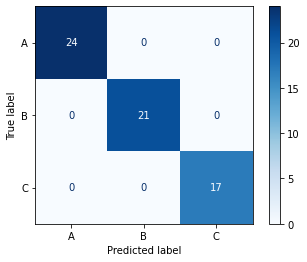

In [26]:
labels = ["A", "B", "C"]

cm = confusion_matrix(y_true2, y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Accuracy
정확도를 본다.

In [27]:
print(accuracy_score(y_true2, y_pred2))

1.0
